## HOG

* https://paper.dropbox.com/doc/HOG-XiA4UdOEtd3tC8jKdZFAU

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIGSIZE=(6,6)

## Helpers

In [258]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

def get_color_hist(img, bins, mask):
    hists = {}
    color = ('r','g','b')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],mask,[bins],[0,256])
        hists[col] = histr
    return hists

# Plotting Histogram (all channels flattened)
def plot_hist(img, bins=256, title=None):
    plt.hist(img.ravel(), bins=bins, range=[0,256])
    plt.title(title)
    plt.show()

def plot_bgr_hist(bgr_img, bins=256, mask=None):
    # Mask let's you select for certain regions    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([bgr_img],[i],mask,[bins],[0,256])
        plt.plot(histr, color=col)
        plt.xlim([0,bins])
    plt.show()

def plot_hists_dict(hists):
    for col,hist in hists.items():
        plt.plot(hist, color=col)
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

def get_img_crop(img, x1, y1, x2, y2):
    if len(img.shape) > 2:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

def plot_boxes(img, rects, title="boxes", color=(255,255,255), thick=2):
    for (x1, y1, x2, y2) in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thick)
    plot_img(img, title=title)

In [259]:
metadata = pd.read_csv(metadata_fpath)
metadata['label_name'] = 'ball'
metadata['label_id'] = 1
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
metadata['fpath'] = fpaths
GT_BOXES = make_boxes(metadata)

## Player Training Data

* https://gist.github.com/danielballan/ab5e28420ba1b24c5ad4

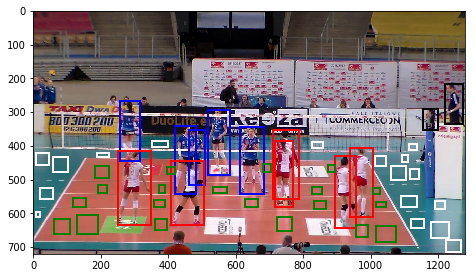

In [260]:
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')

BOX_COLORS = {
    'referee': 'black',
    'red_team': 'red',
    'blue_team': 'blue',
    'court-inner': 'green',
    'court_outer': 'white',
}
        
plot_bbs_from_rectLabel_annos(json_fpath, img_fpath)

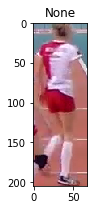

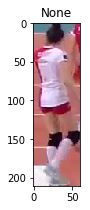

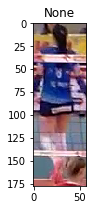

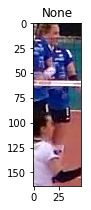

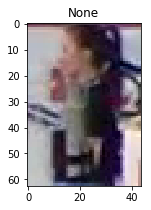

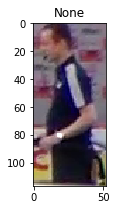

In [312]:
bgr_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
crops = get_img_crops_from_rectLabel_bbs(bgr_img, json_fpath)
for crop in crops['red_team'][:2]:
    plot_img(crop, fs=(3,3))
for crop in crops['blue_team'][:2]:
    plot_img(crop, fs=(3,3))
for crop in crops['referee'][:2]:
    plot_img(crop, fs=(3,3))

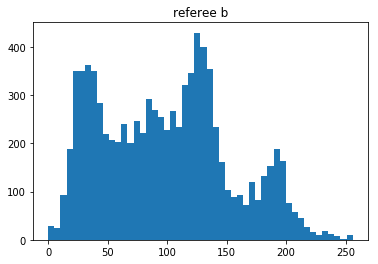

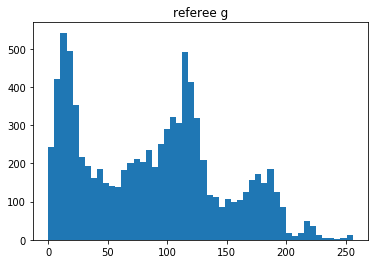

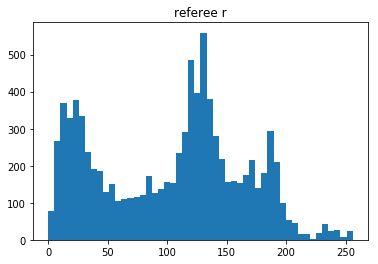

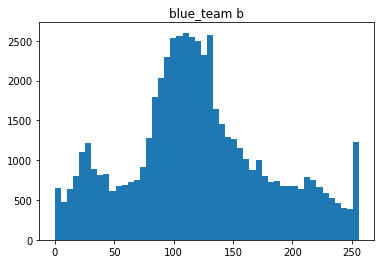

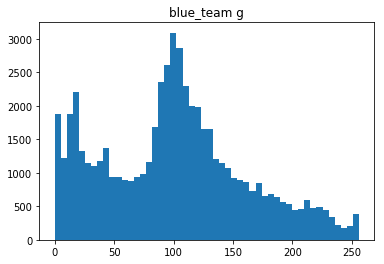

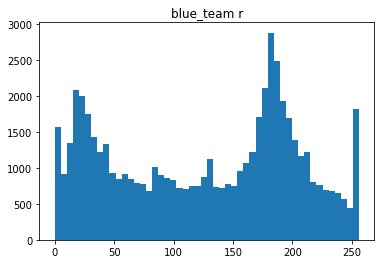

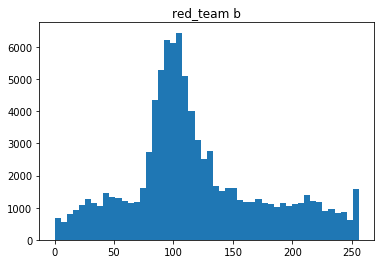

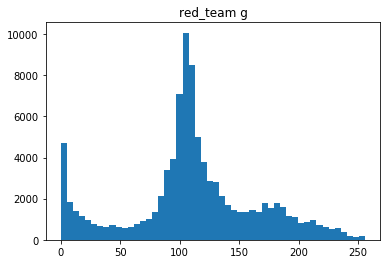

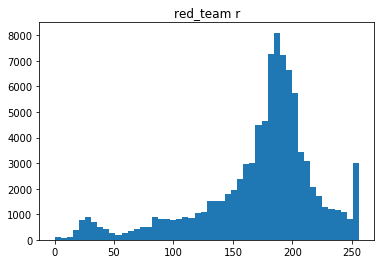

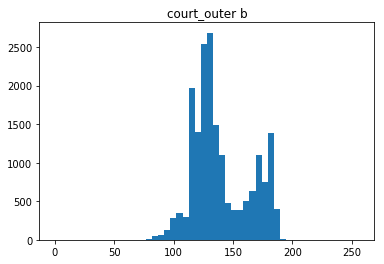

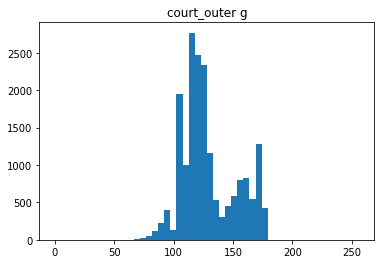

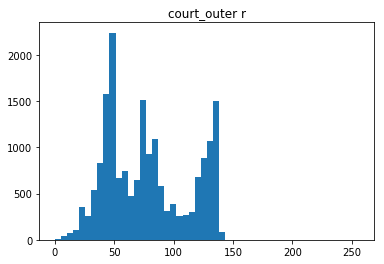

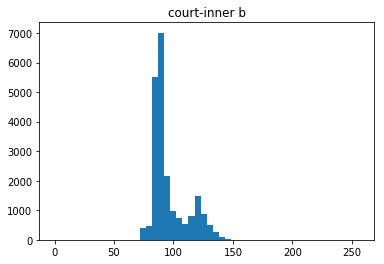

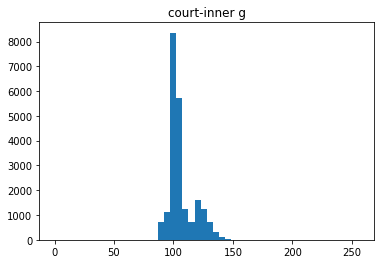

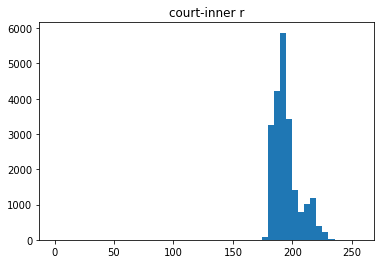

In [267]:
# BGR Histograms
bgr_img = load_cv2_img(img_fpath)
crops = get_img_crops_from_rectLabel_bbs(bgr_img, json_fpath)

hists = {}
for label in crops.keys():
    chans = get_flattened_channels(crops[label])
    bgr = ('b','g','r')
    hists[label] = {
        'b':None,
        'g':None,
        'r':None
    }
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], 50, [0,256])
        hists[label][bgr[i]] = hist
        plot_hist(chans[:,i], bins=50, title=label + ' ' + bgr[i])

In [313]:
# HSV Histograms
hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
crops = get_img_crops_from_rectLabel_bbs(hsv_img, json_fpath)

hists = {}
for label in crops.keys():
    chans = get_flattened_channels(crops[label])
    channels = ('h','s','v')
    hists[label] = {c:None for c in bgr}
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], 50, [0,256])
        hists[label][bgr[i]] = hist
        #plot_hist(chans[:,i], bins=50, title=label + ' ' + channels[i])

## HOG (w SVM)

In [269]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
crops = get_img_crops_from_rectLabel_bbs(img, json_fpath)

In [270]:
def get_people_boxes(img, min_width=1000, stride=(8,8), padding=(8,8), 
                     scale=1.05, non_max_thresh=None):
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
    img = imutils.resize(img, width=min(min_width, img.shape[1]))

    (rects, weights) = hog.detectMultiScale(img, winStride=stride,
        padding=padding, scale=scale)
    
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    
    if non_max_thresh is not None:
        rects = non_max_suppression(rects, probs=None, overlapThresh=non_max_thresh)

    return img, rects

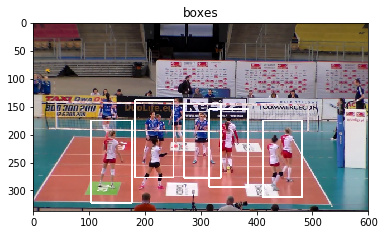

In [271]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
img, boxes = get_people_boxes(img, min_width=600, stride=(8,8), padding=(16,16), 
                              scale=1.05, non_max_thresh=.65)
plot_boxes(img, boxes)

### Search for Params

In [ ]:
widths = [1000]#,1200]
strides = [(2,2),(4,4)]#,(8,8)]#,(16,16)]
padding = [(8,8), (32,32)]
scales = [1.01, 1.03, 1.05]
nms = [None, .3, .6]
params = [{
    'width': 1000,
    'stride': (8,8),
    'padding': (16,16),
    'scale': 1.05,
    'nms': None,
}]

for w in widths:
    for s in strides:
        for pad in padding:
            for scale in scales:
                for nm in nms:
                    title = (w,s,pad,scale,nm)
                    img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
                    img, boxes = get_people_boxes(img, min_width=w, stride=s, padding=pad, 
                                                  scale=scale, non_max_thresh=nm)
                    plot_boxes(img, boxes, title)

### Some Sensible Defaults

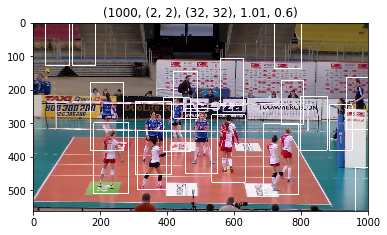

In [272]:
width = 1000
stride = (2,2)
padding = (32,32)
scale = 1.01
nms = .6

title = (width,stride,padding,scale,nms)
img = load_cv2_img(metadata['fpath'][0], colorspace=cv2.COLOR_BGR2RGB)
img, boxes = get_people_boxes(img, min_width=width, stride=stride, padding=padding, 
                              scale=scale, non_max_thresh=nms)
plot_boxes(img, boxes, title)

### Get Boxes

In [296]:
width = 1000
stride = (2,2)
padding = (32,32)
scale = 1.01
nms = .6

def get_boxes(fpaths):
    all_boxes = []
    imgs = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img, bbs = get_people_boxes(
            img, min_width=width, stride=stride, padding=padding, 
            scale=scale, non_max_thresh=nms)
        for (x1, y1, x2, y2) in bbs:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), thickness=2)
        all_boxes.append(bbs)
        imgs.append(img)
    return imgs, all_boxes

## Filter Boxes

### Segment Floor

BGR: [137 127  79]
RGB: [ 79 127 137]
HSV: [ 95 108 137]
Min [ 29.  77.  87.]
Max [ 129.  177.  187.]


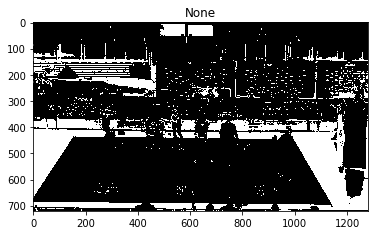

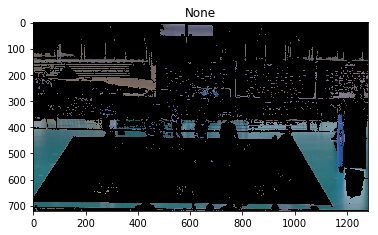

In [297]:
# Highlight floor around court (lighter green reflection)
img_fpath = metadata['fpath'][0]
color = get_color_of_pixel(img_fpath, 1130, 460, 'RGB')
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
mask, masked_img = threshold_color(img, color, 50)
plot_img(mask)
plot_img(masked_img)

### Cleanup Masks

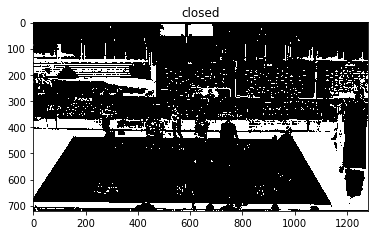

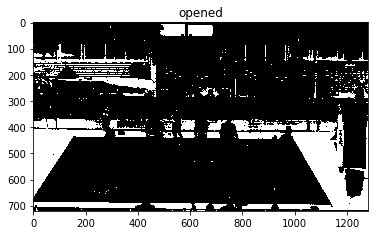

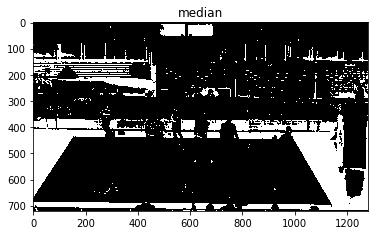

In [298]:
# img
closed_img = closing(mask, ksize=(3,3))
opened_img = opening(mask, ksize=(3,3))
median_img = median_filter(mask, ksize=3)

plot_img(closed_img, title='closed')
plot_img(opened_img, title='opened')
plot_img(median_img, title='median')

### Edge Detection

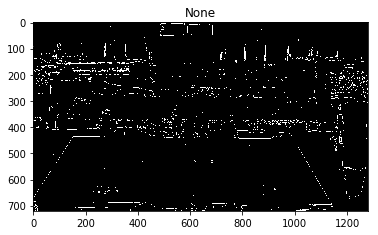

In [299]:
lower_threshold = 100
upper_threshold = 100
edges = cv2.Canny(median_img, lower_threshold, upper_threshold)
plot_img(edges)

### Contours

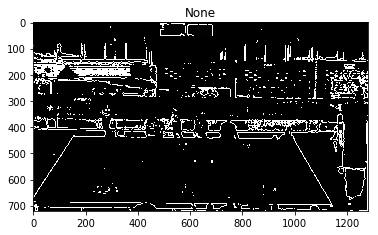

In [300]:
def get_contours(binary_mask):
    image, contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, image

def plot_contours(img, contours, color=(255,255,255), thick=2):
    img = img.copy()
    img = cv2.drawContours(img, contours, -1, color, thickness=thick)
    plot_img(img)

contours, image = get_contours(median_img)
contours_img = median_img.copy()
_ = cv2.drawContours(contours_img, contours, -1, (255,255,255), thickness=2)
plot_img(contours_img)

### Hough Lines

In [304]:
# Higher threshold means a line needs to be stronger to be detected
thresh = 800
hough_img = contours_img

# what does theta control?
# what does the threshold do?
# what is rho?
lines = cv2.HoughLines(hough_img, rho=1, theta=np.pi / 10, threshold=thresh)
# convert polor coordinates to x,y pixel coordinates
# origin (0,0) is top left in numpy/cv2
# p = distance from origin (perpendicular to hough line)
# theta = angle in radians formed by perpendicular line
coords = []
for line in lines:
    for rho, theta in line:
        degrees = theta * (180/math.pi)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * -b)
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * -b)
        y2 = int(y0 - 1000 * a)

        if degrees > 145:
            orient = 'right_vertical'
        elif degrees < 45:
            orient = 'left_vertical'
        elif degrees > 85 and degrees < 95:
            orient = 'horizontal'
        else:
            orient = 'other'
            
        coords.append([x1,y1,x2,y2,rho,theta,degrees,orient])

In [305]:
def plot_lines(img, coords):
    img = img.copy()
    for coord in coords:
        x1,y1,x2,y2,rho,theta,degrees,orient = coord
        cv2.line(img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=4)
    plot_img(img)

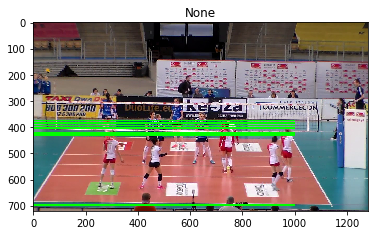

In [306]:
plot_lines(img, coords)

### Get Upper/Lower Court Boundries

In [307]:
max_y,min_y = None,None
for coord in coords:
    #[x1,y1,x2,y2,rho,theta,degrees,orient])
    y = int((coord[1] + coord[3]) / 2)
    if max_y is None or y > max_y:
        max_y = y
        top_line = coord[:4]
    if min_y is None or y < min_y:
        min_y = y
        bottom_line = coord[:4]

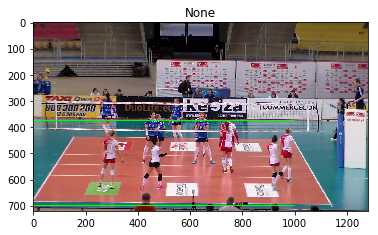

In [308]:
x1,y1,x2,y2 = top_line
cv2.line(img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=4)
x1,y1,x2,y2 = bottom_line
cv2.line(img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=4)
plot_img(img)

### Filter Boxes

In [309]:
def filter_boxes(boxes, min_y, max_y, margin=0):
    filtered_boxes = []
    for img_boxes in boxes:
        good_boxes = []
        for coords in img_boxes:
            bottom_y = coords[3]
            if bottom_y < max_y and bottom_y > min_y:
                good_boxes.append(coords)
        filtered_boxes.append(good_boxes)
    return filtered_boxes

In [310]:
imgs, boxes = get_boxes(metadata['fpath'][:5])

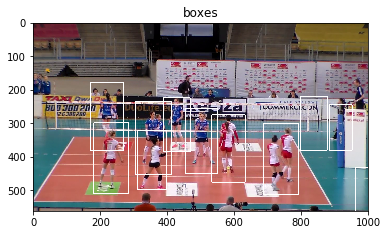

In [311]:
filtered_boxes = filter_boxes(boxes, min_y, max_y, margin=3)
img = load_cv2_img(metadata['fpath'][0], colorspace=cv2.COLOR_BGR2RGB)
img = imutils.resize(img, width=min(width, img.shape[1]))
plot_boxes(img, filtered_boxes[0])

## Team Classification

In [ ]:
bm1 = binary_masks[0].copy()
cm1 = color_masks[0].copy()
for bb,cmean,hist in zip(bbs, color_means, color_hists):
    bm_crop = get_img_crop(bm1, bb[0],bb[1],bb[2],bb[3])
    cm_crop = get_img_crop(cm1, bb[0],bb[1],bb[2],bb[3])
    plot_img(bm_crop, fs=(4,4))
    plot_img(cm_crop, fs=(4,4))
    plot_hists_dict(hist)
    print(cmean)

## Links

* https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
* https://www.learnopencv.com/histogram-of-oriented-gradients/
* https://www.learnopencv.com/image-recognition-and-object-detection-part1/
* https://github.com/BUPTLdy/human-detector
* https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python
* https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
* http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
* http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/
* https://www.learnopencv.com/histogram-of-oriented-gradients/
* https://stackoverflow.com/questions/34985196/opencv-using-svm-and-hog-for-person-detection
* https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/